![*INTERTECHNICA - SOLON EDUCATIONAL PROGRAMS - TECHNOLOGY LINE*](https://solon.intertechnica.com/assets/IntertechnicaSolonEducationalPrograms-TechnologyLine.png)

# Python for Data Preparation

*This notebook will focus on preparing data using Python*.

Initializing environment for machine learning use:

In [1]:
!python -m pip install numpy
!python -m pip install matplotlib
!python -m pip install sklearn

## 1 Data Loading & Minimal Processing

We will use the **Cleveland Heart Disease Data Set** from University of California Irvine. This dataset is focused on heart disease prediction based on several personal health indicators. 

We will load the raw data in textual format so we can process it even if there are formatting errors:

In [2]:
import numpy as np

# import packages for remote data load
import requests
import io

# read data remotely
data_url = "https://raw.githubusercontent.com/INTERTECHNICA-BUSINESS-SOLUTIONS-SRL/Applying-Python-in-Machine-Learning/master/notebooks/data/data_exploration_processed_cleveland_data.csv"
response = requests.get(data_url)

raw_data = np.loadtxt(
    io.StringIO(response.text),
    skiprows = 0, 
    delimiter = ",", 
    dtype = {
            "names" : (
                "age", #age in years 
                "sex", #sex (1 = male; 0 = female) 
                "cp", #chest pain type:  1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic   
                "trestbps", #resting blood pressure (in mm Hg on admission to the hospital) 
                "chol", #serum cholestoral in mg/dl 
                "fbs", #fasting blood sugar > 120 mg/dl (1 = true; 0 = false) 
                "restecg", #resting electrocardiographic results (0: normal, 1: having ST-T wave abnormality,  
                           #                        2: showing probable or definite left ventricular hypertrophy)
                "thalach", #maximum heart rate achieved 
                "exang", #exercise induced angina (1 = yes; 0 = no) 
                "oldpeak", #ST depression induced by exercise relative to rest 
                "slope", #the slope of the peak exercise ST segment (1: upsloping, 2: flat, 3: downsloping)
                "ca", #number of major vessels (0-3) colored by flourosopy 
                "thal", #3 = normal; 6 = fixed defect; 7 = reversable defect, ? = unknown 
                "diagnosis", #diagnosis of heart disease (angiographic disease status)  
                         # 0: no heart disease
                         # 1-4: heart disease present
                         #target variable   
            ),
            "formats": ["U20"] * 14 }
)

# register metadata information
categorical_attribute_names = np.array(["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"])
numerical_attribute_names = np.array(["chol", "age", "trestbps", "thalach", "oldpeak", "ca"])
attribute_names = np.concatenate((categorical_attribute_names, numerical_attribute_names))

Let's find the shape of the raw data: 

In [3]:
print("Raw data has {} rows and {} columns.".format(raw_data.shape[0], len(raw_data.dtype.names)))

Raw data has 303 rows and 14 columns.


Let's see also the first 10 records of data:

In [4]:
print(raw_data[0:10])

[('63.0', '1.0', '1.0', '145.0', '233.0', '1.0', '2.0', '150.0', '0.0', '2.3', '3.0', '0.0', '6.0', '0')
 ('67.0', '1.0', '4.0', '160.0', '286.0', '0.0', '2.0', '108.0', '1.0', '1.5', '2.0', '3.0', '3.0', '2')
 ('67.0', '1.0', '4.0', '120.0', '229.0', '0.0', '2.0', '129.0', '1.0', '2.6', '2.0', '2.0', '7.0', '1')
 ('37.0', '1.0', '3.0', '130.0', '250.0', '0.0', '0.0', '187.0', '0.0', '3.5', '3.0', '0.0', '3.0', '0')
 ('41.0', '0.0', '2.0', '130.0', '204.0', '0.0', '2.0', '172.0', '0.0', '1.4', '1.0', '0.0', '3.0', '0')
 ('56.0', '1.0', '2.0', '120.0', '236.0', '0.0', '0.0', '178.0', '0.0', '0.8', '1.0', '0.0', '3.0', '0')
 ('62.0', '0.0', '4.0', '140.0', '268.0', '0.0', '2.0', '160.0', '0.0', '3.6', '3.0', '2.0', '3.0', '3')
 ('57.0', '0.0', '4.0', '120.0', '354.0', '0.0', '0.0', '163.0', '1.0', '0.6', '1.0', '0.0', '3.0', '0')
 ('63.0', '1.0', '4.0', '130.0', '254.0', '0.0', '2.0', '147.0', '0.0', '1.4', '2.0', '1.0', '7.0', '2')
 ('53.0', '1.0', '4.0', '140.0', '203.0', '1.0', '2.0',

## 2 Exploring missing data

Missing data is a common occurance in Machine Learning. We know that the symbol '?' has been used to encode missing data. Let's find out how many records have missing data:

In [5]:
# let's drop all records which have at least one field equal to "?"
valid_data = raw_data.copy()

for attribute_name in attribute_names :
    valid_data = valid_data[np.where(~(valid_data[attribute_name ] == '?'))] 

# print number of missing records
print("Number of missing data records: {}".format(raw_data.shape[0] - valid_data.shape[0]) )

Number of missing data records: 6


We have only a small number of missing records, so it is acceptable to move forward with dropping missing data.

## 3 Processing numerical attributes

We will select and process the numerical data so that it can handled by the prediction models.

### 3.1 Data Encoding

The first activity that will be done is data encoding. We will encode the raw data into a numerical representation.

In [6]:
numerical_data = valid_data[numerical_attribute_names]
numerical_data_types = np.dtype({
                        "names" : numerical_data.dtype.names,
                        "formats" : [float] * len(numerical_data.dtype.names)
                    })
numerical_data = numerical_data.astype(numerical_data_types) 

### 3.2 Data Scaling

The data needs to be scaled so it has a more appropriate representation across the entire dataset. One method for scaling the data is by using the **RobustScaler** transformer from sklearn.

In [7]:
from sklearn.preprocessing import RobustScaler

scalers = {}
scaled_data = np.zeros(numerical_data.shape[0], dtype=numerical_data.dtype)

for attribute_name in numerical_attribute_names :
    # instantiate and fit a robust scaler
    scalers[attribute_name] = RobustScaler()
    scalers[attribute_name].fit(numerical_data[attribute_name].reshape((-1,1)))
    
    # transform the data
    transformed_data = scalers[attribute_name].transform(numerical_data[attribute_name].reshape((-1,1)))
    
    #store the data
    scaled_data[attribute_name] = transformed_data.reshape(scaled_data.shape[0])

### 3.3 Data Normalization

We observed during the data exploration phase that the numerical data is either right or left skewed. Many algorithms work best if the data is normally distributed; some of the best normalization algorithms are the **BoxCox** and **Yeo-Johnson** transformations.  
One method for normalizing the data is by using the **PowerTransformer** transformer from sklearn which supports both normalization algorithms.

In [8]:
from sklearn.preprocessing import PowerTransformer

normalizers = {}
normalized_data = np.zeros(scaled_data.shape[0], dtype=numerical_data.dtype)

for attribute_name in numerical_attribute_names :
    # instantiate and fit a robust scaler
    # Yeo-Johnson transformation will be used by default
    normalizers[attribute_name] = PowerTransformer()
    normalizers[attribute_name].fit(scaled_data[attribute_name].reshape((-1,1)))
    
    # transform the data
    transformed_data = normalizers[attribute_name].transform(scaled_data[attribute_name].reshape((-1,1)))
    
    #store the data
    normalized_data[attribute_name] = transformed_data.reshape(scaled_data.shape[0])

A good way to remove unnecessary noise from data is to perform a truncation for the decimal values:

In [9]:
processed_numerical_data = np.zeros(normalized_data.shape[0], dtype=numerical_data.dtype)
for attribute_name in numerical_attribute_names :
    processed_numerical_data[attribute_name] = np.trunc(normalized_data[attribute_name] * 1000)/1000

Let's see the data for the first 10 records:

In [10]:
print(processed_numerical_data[0:10])

[(-0.173,  0.937,  0.816, -0.103,  1.182, -0.828)
 ( 0.821,  1.446,  1.481, -1.637,  0.712,  1.576)
 (-0.261,  1.446, -0.621, -0.937,  1.319,  1.38 )
 ( 0.178, -1.816,  0.024,  1.926,  1.652, -0.828)
 (-0.857, -1.439,  0.024,  1.016,  0.638, -0.828)
 (-0.108,  0.104, -0.621,  1.367,  0.083, -0.828)
 ( 0.514,  0.814,  0.57 ,  0.37 ,  1.684,  1.38 )
 ( 1.816,  0.218, -0.621,  0.524, -0.162, -0.828)
 ( 0.256,  0.937,  0.024, -0.234,  0.638,  0.924)
 (-0.882, -0.227,  0.57 ,  0.125,  1.517, -0.828)]


Let's observe if the data got closer to a normal distribution as a result of these transformations:

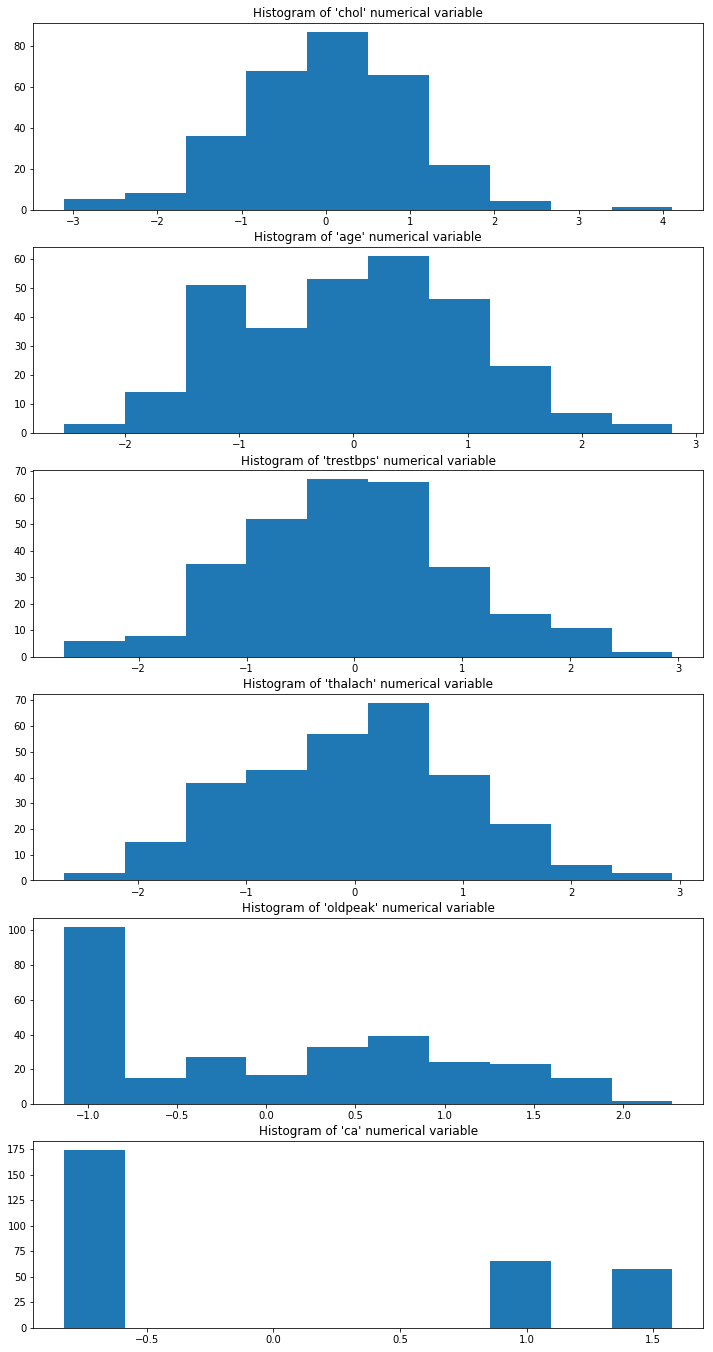

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# prepare the subplot infrastructure 
count_attributes_ploted = len(numerical_attribute_names)
fig, axes = plt.subplots (
    count_attributes_ploted, 
    figsize=(2*count_attributes_ploted, 4*count_attributes_ploted)
)
index = 0

# plot data 
for var_name in numerical_attribute_names : 
    # get the variable data
    var_data = processed_numerical_data[var_name]

    # plot each variable in each own's subplot
    axes[index].hist(var_data)
    axes[index].title.set_text("Histogram of '{}' numerical variable".format(var_name))
    
    index = index + 1
    
plt.show()

It seems that the data got closer to a normal distribution, thus being more appropriate for processing.

## 4 Processing categorical attributes

We will select and process the categorical data so that it can handled by the prediction models.

### 4.1 Selecting categorical data

We will select the categorical data based on the known attribute names.

In [12]:
categorical_data = valid_data[categorical_attribute_names]

### 4.1 One Hot Encoding

The one-hot encoder will create an array of indexes for each categorical value. The length of the array will be the number of the categories; the values will be 0 except the current category value where it will be 1.  
The one hot encoding can be performed with the **OneHotEncoder** transformer from sklearn.

In [13]:
from sklearn.preprocessing import OneHotEncoder

# initialize encoding models
one_hot_encoders = {}
encoded_data = None
category_names = []

# encode attribute by attribute
for attribute_name in categorical_attribute_names :
    
    # create and fit encoder 
    one_hot_encoders[attribute_name] = OneHotEncoder(sparse = False, categories='auto')
    one_hot_encoders[attribute_name].fit(categorical_data[attribute_name].reshape((-1,1)))
    
    # transform data 
    transformed_data = one_hot_encoders[attribute_name].transform(categorical_data[attribute_name].reshape((-1,1)))
    
    # re-align data to be consisted with a record-like model
    transformed_data = np.split(
        transformed_data, 
        len(one_hot_encoders[attribute_name].categories_[0]),
        axis = 1)
    
    transformed_data = np.array(transformed_data).reshape(len(one_hot_encoders[attribute_name].categories_[0]), -1,)
    transformed_data = transformed_data.T
    
    # obtain and store category names
    transformed_category_names = one_hot_encoders[attribute_name].get_feature_names([attribute_name])
    category_names = np.append(category_names, transformed_category_names)

    # store encoded data as it is generated
    if encoded_data is None :
        encoded_data = transformed_data
    else :
        encoded_data = np.concatenate((encoded_data, transformed_data), axis = 1)

# set the type of data as having the names of each category and value type int 
processed_categorical_data_type = np.dtype({
    "names" : category_names,
    "formats" : [int] * len(category_names)
}) 

# transform record array into the proper type 
processed_categorical_data = np.rec.fromrecords(encoded_data.astype(int)).astype(processed_categorical_data_type)

Let's observe which are the categories generated by the one-hot encoders:

In [14]:
print("Categories generated by the one-hot encoders : \n {} \n There are {} categories".format(
    processed_categorical_data.dtype.names, 
    len(processed_categorical_data.dtype.names))
)

Categories generated by the one-hot encoders : 
 ('sex_0.0', 'sex_1.0', 'cp_1.0', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'fbs_0.0', 'fbs_1.0', 'restecg_0.0', 'restecg_1.0', 'restecg_2.0', 'exang_0.0', 'exang_1.0', 'slope_1.0', 'slope_2.0', 'slope_3.0', 'thal_3.0', 'thal_6.0', 'thal_7.0') 
 There are 19 categories


Let's see the data for the first 10 records:

In [15]:
print(processed_categorical_data[0:10])

[(0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0)
 (0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0)
 (0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1)
 (0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0)
 (1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0)
 (0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0)
 (1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0)
 (1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0)
 (0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1)
 (0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1)]


## 5 Processing the target variable 

Let's process the target variable as well:

In [16]:
# get raw target data information
target_variable_name = "diagnosis" 
raw_data_target = valid_data[target_variable_name]

We will transfom the data so that it will have only 2 classes:

In [17]:
#convert target data to int codes    
target_data = raw_data_target.astype(int)

#force target data to 0 - no heart disease, 1 - heart disease present
target_data[target_data > 0] = 1

## 5 Putting all together

Finally, putting together all the data from both numerical and categorical processed datasets will lead to the final result.

In [18]:
# we will create raw normalized and encoded data
raw_numerical_data = processed_numerical_data.view(float).reshape(-1, len(processed_numerical_data.dtype.names))
raw_categorical_data = processed_categorical_data.view(int).reshape(-1, len(processed_categorical_data_type.names))
raw_target_data = target_data.view(int).reshape(-1, 1)

# concatenating this data will lead to the final result
raw_processed_data = np.concatenate((raw_numerical_data, raw_categorical_data, raw_target_data), axis = 1)

Let's transform the raw data into a record array:

In [19]:
processed_data_type = np.dtype({
    "names" : np.concatenate((scaled_data.dtype.names, processed_categorical_data_type.names, [target_variable_name])),
    "formats" : np.concatenate(([float] * len(numerical_data.dtype.names), [int] * len(processed_categorical_data_type.names), [int]))
})

processed_data = np.rec.fromrecords(raw_processed_data).astype(processed_data_type)

Let's see the first 10 records of processed data:

In [20]:
print(processed_data[0:10])

[(-0.173,  0.937,  0.816, -0.103,  1.182, -0.828, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0)
 ( 0.821,  1.446,  1.481, -1.637,  0.712,  1.576, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1)
 (-0.261,  1.446, -0.621, -0.937,  1.319,  1.38 , 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1)
 ( 0.178, -1.816,  0.024,  1.926,  1.652, -0.828, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0)
 (-0.857, -1.439,  0.024,  1.016,  0.638, -0.828, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0)
 (-0.108,  0.104, -0.621,  1.367,  0.083, -0.828, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0)
 ( 0.514,  0.814,  0.57 ,  0.37 ,  1.684,  1.38 , 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1)
 ( 1.816,  0.218, -0.621,  0.524, -0.162, -0.828, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0)
 ( 0.256,  0.937,  0.024, -0.234,  0.638,  0.924, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1)
 (-0.882, 

The data can be saved in a CSV file for further processing using numpy's **savetxt** function:

In [21]:
np.savetxt(
    "./data_processing_processed_cleveland_data.csv", 
    processed_data,
    header = ",".join(processed_data_type.names),
    delimiter = ',', 
    fmt = "%.3f"
)